# Определение возраста покупателей

# Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

**Задача:**  Построить  модель, которая по фотографии определит приблизительный возраст человека. 
В нашем распоряжении набор фотографий людей с указанием возраста.

# Описание данных 
Данные взяты с сайта [Looking at People](http://chalearnlap.cvc.uab.es/dataset/26/description/ChaLearn). Они находятся в папке /datasets/faces/. 
В нашем распоряжении одна папка со всеми изображениями (/final_files) и CSV-файл labels.csv с двумя колонками: file_name и real_age. 
Извлечь данные из папки нам поможет новый метод ImageDataGenerator —flow_from_dataframe(dataframe, directory, ...).

# План работы 

1. Исследовательский анализ набора фотографий.
- Посмотреть на размер выборки.
- Построить график распределения возраста в выборке.
- Напечатать на экране 10–15 фотографий и посмотреть, как устроен датасет.
2. Подготовка данных к обучению.
3. Обучение нейронной сеть и рассчет её качества.


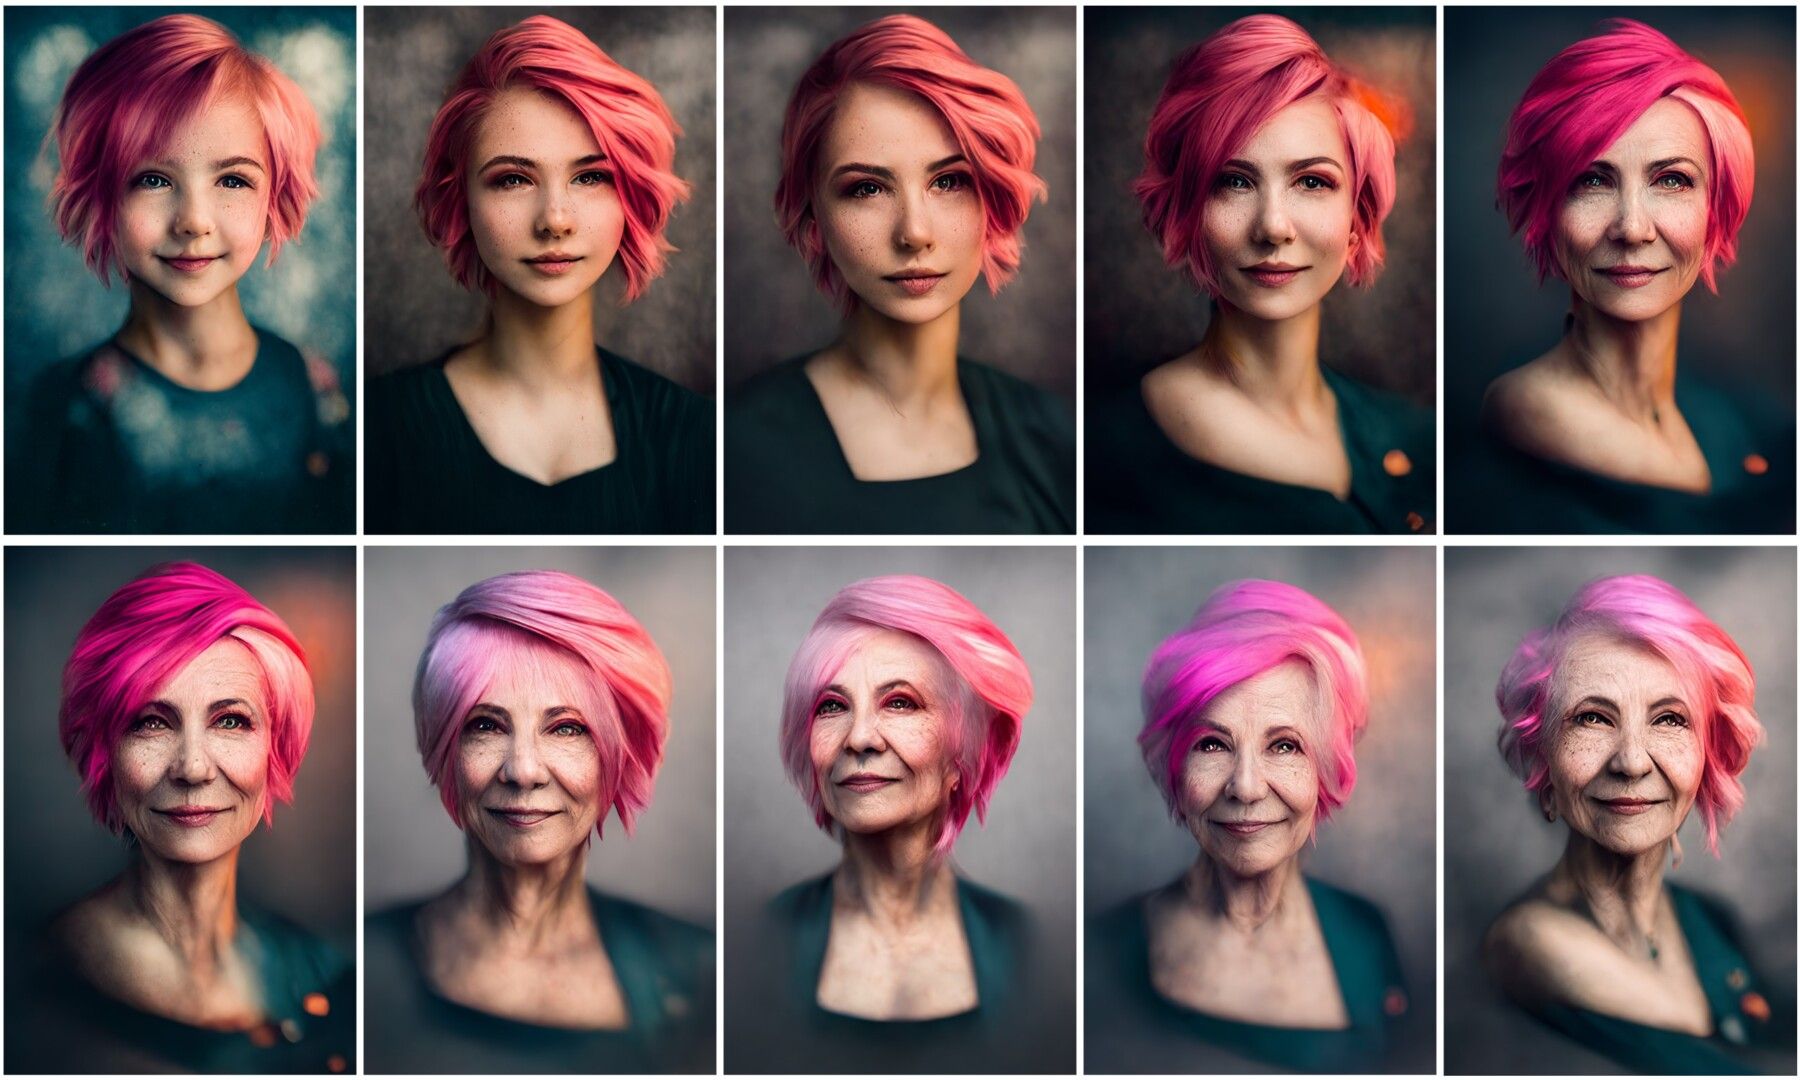

## Исследовательский анализ данных

### Импортируем библиотеки 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50


### Изучим набор фотографий

**Считаем данные из csv-файла в датафрейм и сохраним в переменную**

Загружаем данные о метках из файла CSV

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')

**Ознакомимся с информацией о датафрейме и размере выборки**

In [4]:
display(labels.head())
labels.info()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Набор содержит 7591 фотографий в формате .jpg. Датасет сдвумя столбцами: `file_name` (имя файла) и `real_age` (реальный возраст). Необходимо предсказывать возраст человека по фотографии в задаче регрессии.

Количество данных в датасете является относительно большим, что может быть достаточнм для обучения модели при условии, что изображения разнообразные и в приемлемом качестве. Ткже успех будет зависеть от выбора модели и настройки параметров и обработки данных. 

**Чтобы понять, что данных достаточно, необходимо исследовать набор фотографий и проверить:**
- **Разнообразие возрастов**, представленных в датасете. Если датасет содержит фотографии людей с широким диапазоном возрастов, это поможет модели лучше обобщать и предсказывать возрасты для разных групп.
- **Качество разметки:** возраста, указанные в столбце 'real_age', должны бть достоверными и точными. Некорректные или неточные  затруднят обучение модели.
- **Качество изображений** в наборе данных. Высокое разрешение и качество сьемки помогут модели выявлять важные признаки для предсказания возраста.
- **Репрезентативность:** Фотографии должны быть репрезентативными для целевой группы людей, которых мы будем анализировать.

**Построим гистограмму распределения возраста в выборке**

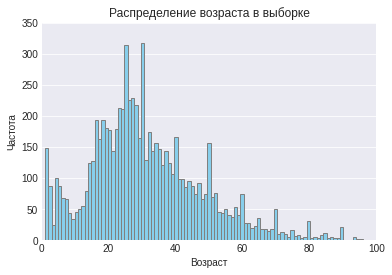

In [5]:
ages = labels['real_age']
plt.style.use('seaborn-darkgrid')
plt.hist(ages, bins=100, color='skyblue', edgecolor='gray')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.title('Распределение возраста в выборке')

plt.xlim(0, 100)
plt.ylim(0, 350)
plt.grid(axis='x', alpha=0.9)

plt.show()

Распределение похоже на распределение Пуассона со смещением влево и провалом в районе 10 лет: 

- Недостаточное количество образцов в провале возрастов: модель может испытывать затруднения в обучении и предсказании возрастов в этом диапазоне (быть менее точной и более склонной к ошибкам в предсказаниях в этой области).

- Смещение влево: модель может быть более успешной в предсказании средних и младших возрастов, поскольку они представлены более часто в наборе данных, и иметь тенденцию недооценивать возраст людей в старшей возрастной группе или наоборот, надоценивать возраст молодых людей.

- Возможно создатели набора пытались отдаленно повторить реальную картину распределения возрастов населения какой-нибудь страны: долгожителей довольно мало, высокая рождаемость и детская смертность. Хотя, маловероятно. Мне не удалось найти похожие графики ни на одном континенте. Млохо искала :) 

**Создадим генератор для обучающих данных изображений и генератор потока данных изображений из DataFrame** с параметрами: 
- Размер изображений после масштабирования - 224x224, 
- Размер пакета (количества изображений в одном шаге обучения) - 32

In [6]:
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345)

Found 7591 validated image filenames.


**Загрзим и выведем на экран первые 15 изображений из датасета** 

Загрузим датасет для работы с ним.

In [7]:
image_dir = '/datasets/faces/final_files/'

Создадим функцию для 15 изображений, которая создаст фигуру и подграфики, загрузит и отобразит каждое изображение в переданном срезе на соответствующем подграфике.

In [30]:
def display_images_age(image_slice):
    fig, axes = plt.subplots(3, 5, figsize=(12, 8))

    for i, file_name in enumerate(image_slice):
        row = labels.loc[labels['file_name'] == file_name]
        file = row['file_name'].values[0]
        image_path = image_dir + file
        image = Image.open(image_path)
        axes[i // 5, i % 5].imshow(image)
        axes[i // 5, i % 5].axis('off')

        real_age = row['real_age'].values[0]
        axes[i // 5, i % 5].set_title(f'Age: {real_age}')

    plt.tight_layout()
    plt.show()

**Выведем на экран некоторые изображения из выборки**

- Первые 15 изображений:

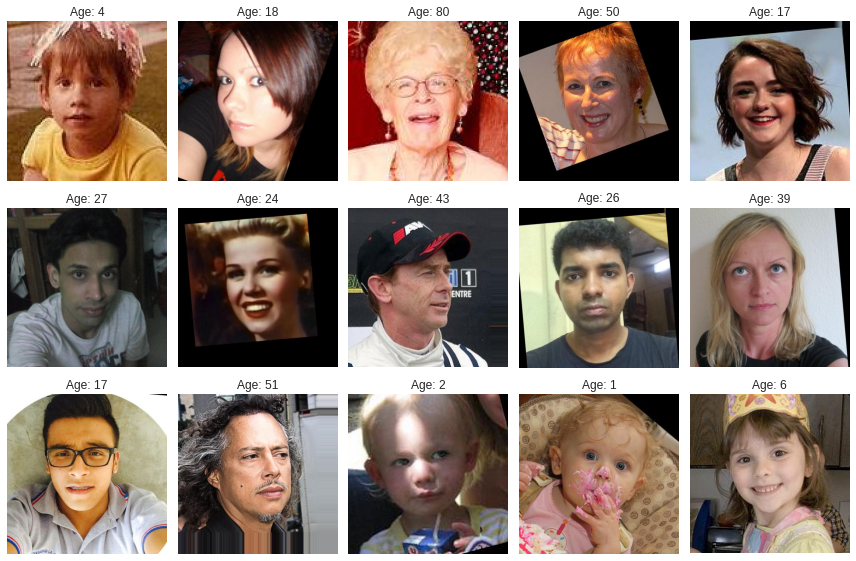

In [31]:
display_images_age(labels['file_name'].iloc[:15])

- Изображения из средней части выборки 

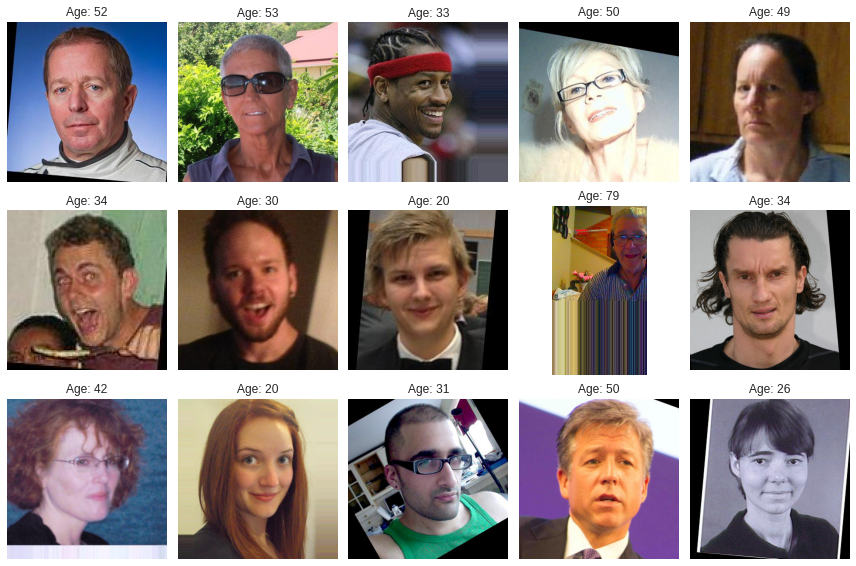

In [32]:
display_images_age(labels['file_name'].iloc[3010:3025])

- Последние 15 изображений выборки 

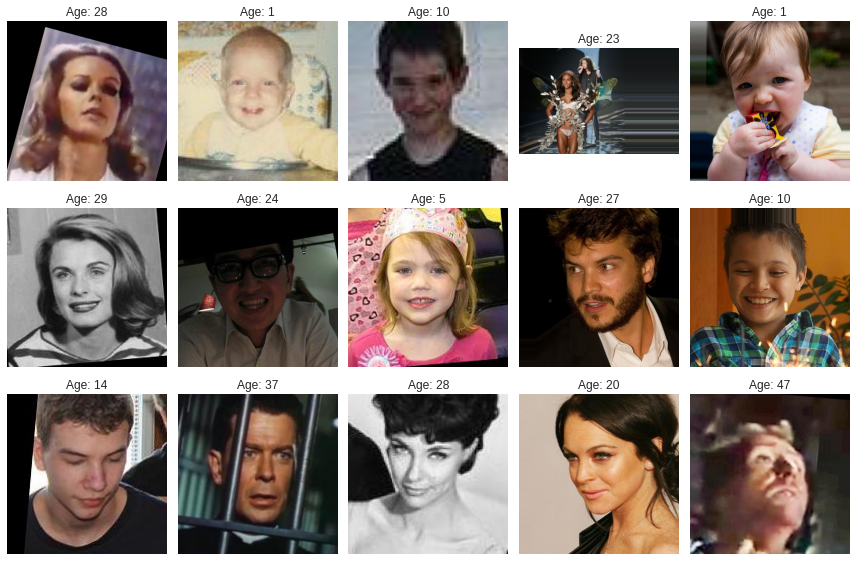

In [33]:
display_images_age(labels['file_name'].iloc[7576:7591])

Разнообразный набор изображений (яркость, контрастность, зернистость, качество изображений отличается, также ракурсы различные и некоторые лица закрыты предметами), и это обладает как положительными, так и отрицательными аспектами для обучения модели.

**Положительные аспекты:**

- Разнообразность: Набор содержит разные возраста, что помогает модели обучиться распознавать лица людей в разных стадиях жизни.
- Различные условия съемки: Включение фотографий различного качества, размеров, яркости и контрастности поможет модели стать устойчивой к вариациям входных данных.
- Разнообразные позы и углы: Включение фотографий под разными углами и с различными позами может помочь модели учиться распознавать лица в нестандартных положениях.

**Отрицательные аспекты:**

- Низкое качество и зернистость: Если качество фотографий слишком низкое или зернистое, это может затруднить обучение модели, поскольку она может столкнуться с трудностями в извлечении достоверных признаков изображений.
- Плохая видимость лиц: Если некоторые изображения имеют плохую видимость лиц, это может усложнить обучение модели, поскольку она может испытывать трудности в выделении и распознавании лиц людей.

На проверку всего датасета потребуется довольно много времени, потому допустим, что 45 фотографий, которые выведены на экран выше, являются репрезентативной подвыборкой из всего набора данных. 
Глядя на фотографии моджно сказать, что большинство изображений -  хорошего качества и показывают ясные и видимые лица,  это может быть хорошей основой для обучения модели. Также аргументация данных  может быть полезна для улучшения результатов обучения модели. 



**ВЫВОД:** 
- Набор содержит 7591 фотографий в формате .jpg.
- Это фотографии людей разного возраста. 
- Разнообразный набор изображений может быть полезным, поскольку он позволяет модели учиться на различных вариациях данных, что помогает ей обобщать и обучаться более гибким и адаптивным представлениям.
- Качество изображений может повлиять на результаты обучения. Если слишком много изображений имеют низкое качество или плохую видимость лиц, модель может столкнуться с трудностями в обучении эффективному распознаванию лиц.  
- На проверку всего датасета потребуется довольно много времени, потому допустим, что 45 фотографий, которые выведены на экран выше, являются репрезентативной подвыборкой из всего набора данных. Глядя на фотографии моджно сказать, что большинство изображений -  хорошего качества и показывают ясные и видимые лица,  это может быть хорошей основой для обучения модели. 
- Также аргументация данных  может быть полезна для улучшения результатов обучения модели. 
- Распределение возрастов в наборе похоже на распределение Пуассона со смещением влево и провалом в районе 10 лет: 
 - Меньшее количество образцов в провале возрастов: модель может испытывать затруднения в обучении и предсказании возрастов в этом диапазоне (быть менее точной и более склонной к ошибкам в предсказаниях в этой области).
 - Смещение влево: модель может быть более успешной в предсказании средних и младших возрастов, поскольку они представлены более часто в наборе данных, и иметь тенденцию недооценивать возраст людей в старшей возрастной группе или наоборот, надоценивать возраст молодых людей.

## Обучение модели

### Постановка задачи:
Построить и обучить свёрточную нейронную сеть на датасете с фотографиями людей.  
**Добиться значения MAE на тестовой выборке не больше 8.**

В коде должны быть функции:
- load_train(path),
- load_test(path),
- create_model(input_shape),
- train_model(model, train_data, test_data, batch_size, epochs, steps_per_epoch, validation_steps).


### Подготовка данных, обучение и проверка модели

**Описание действий:** 

- Загрузим обучающую и тестовую выборку. 
- Проведем предобработку изображений в каждой выборке с ImageDataGenerator (масштабирование, 
горизонтальный переворот, сдвиги изображений).
- Создадим и скомпилируем модель глубокого обучения с использованием архитектуры ResNet50 в качестве основы (backbone). ResNet50 - это предварительно обученная сверточная нейронная сеть, которая имеет 50 слоев и обучалась на большом наборе изображений ImageNet.

**Описание модели**:  

- Обычно нейронные сети с большим числом слоёв сильно переобучаются, потому не будем создавать большое количество слоев, чтоб избежать переобучения модели. 

- Создадим и скомпилируем модель глубокого обучения с использованием архитектуры ResNet50 в качестве основы (backbone). 
ResNet50 - это предварительно обученная сверточная нейронная сеть, которая имеет 50 слоев и обучалась на большом наборе изображений ImageNet.

- Добавим слой GlobalAveragePooling2D(), который преобразует пространственные признаки, полученные от ResNet50, в одномерный вектор путем усреднения значений признаков по всем позициям.

- Далее добавим полносвязный слой Dense(1, activation='relu'), который содержит один нейрон с активацией ReLU. Этот слой выполняет финальную классификацию или регрессию на основе извлеченных признаков.

- Функцией потерь не обязательно должна быть MAE. Зачастую нейронные сети с функцией потерь MSE обучаются быстрее.
Модель компилируем с помощью функции compile(). Определим параметры оптимизатора, функция потерь (в данном случае 'mean_squared_error' - среднеквадратичная ошибка) и метрики оценки модели (в данном случае средняя абсолютная ошибка - 'mae').

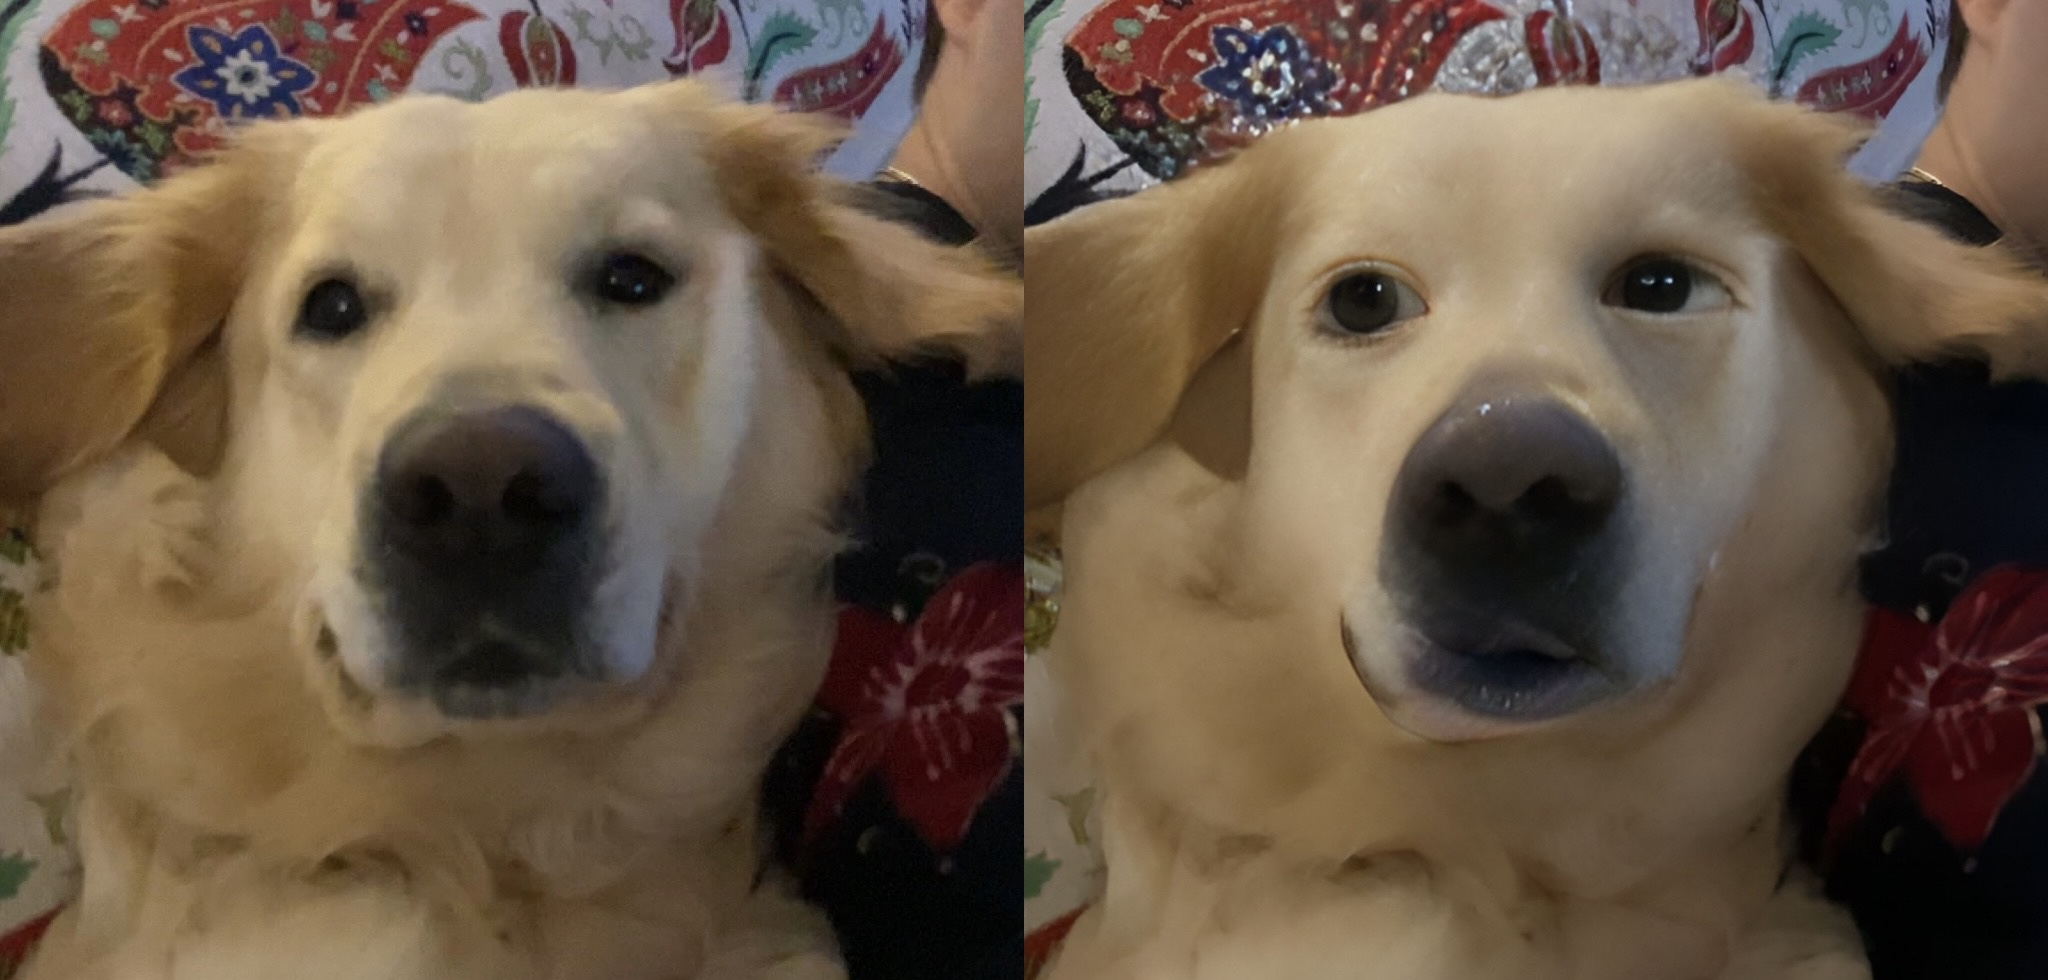

**Перенесите сюда код обучения модели и её результат вывода на экран.
(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)**

#### Функции для подготовки данных и создания и проверки модели

```python

#Создание оптимизатора Adam с коэффициентом обучения 0.0001

optimizer = Adam(0.0001)

#Загрузка обучающей выборки 

def load_train(path):

    '''
    Функция загружает обучающую выборку. Внутри функции используется объект
    ImageDataGenerator для предобработки изображений. Изображения масштабируются,
    горизонтально переворачиваются, и выполняются другие операции аугментации данных.

    Затем создается генератор данных с помощью метода flow_from_dataframe(), который
    считывает данные из файла CSV и изображения из указанной директории. Генератор
    возвращает пакеты данных с заданным размером (batch_size) и их соответствующие метки.
    '''
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        horizontal_flip=True,
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2
    )
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    return train_gen_flow

#Загрузка тестовой выборки 

def load_test(path):

    ''' Функция загружает тестовую выборку. Она использует тот же процесс предобработки данных, 
    что и функция load_train(). Также создается генератор данных с помощью метода 
    flow_from_dataframe(), но указывается параметр subset='validation', 
    чтобы получить подмножество данных, используемых для валидации модели.
    '''

    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255
    )
    test_gen_flow = datagen.flow_from_dataframe(

        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=123
        
#Создание содели 
def create_model(input_shape):

    '''функция создает модель нейронной сети. Используется предварительно обученная модель ResNet50 
    в качестве базовой модели (backbone). К ней добавляются слои GlobalAveragePooling2D() и Dense(). 
    После компиляции модели с оптимизатором, функцией потерь и метриками, модель возвращается.
    '''
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 

    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
    return model

#Запуск модели
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
                
    '''функция обучает модель. Она вызывает метод fit() модели, передавая обучающую и тестовую выборки, 
    параметры пакета (batch_size), количество эпох (epochs) и другие параметры. 
    Модель обучается на обучающих данных и проверяется на тестовых данных. 
    Обученная модель возвращается из функции.
    '''
        
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```        

### Результат запуска модели 

**ВЫВОД** 
- Модель показывает улучшение по мере увеличения числа эпох обучения на тренировочном наборе данных. 
- Результат на тестовом наборе данных (Test MAE: 7.2153) указывает на среднюю абсолютную ошибку модели при применении ее к новым, ранее не виденным данным. Сравнивая это значение с тренировочным и валидационным MAE, можно сказать, что модель имеет хорошую способность обобщения и обладает некоторой предсказательной силой на новых данных. Кроме того, значения MAE на тестовой выборке меньше 8, что отвечает требованиям задач.

## Анализ обученной модели

- За 10 эпох обучения модели значение функции потерь (loss) снизилось с 315.8914 до 64.3888 на тренировочном наборе данных. Модель постепенно настраивается на обучающие данные и уменьшает ошибку прогнозирования.
- Значение средней абсолютной ошибки (MAE) также снижается от 13.0463 до 6.1234 на тренировочном наборе данных. Модель становится лучше в прогнозировании целевых значений и уменьшает среднюю абсолютную ошибку.
- На валидационном наборе данных модель показывает результаты несколько хуже. Значения функции потерь и средней абсолютной ошибки на валидации варьируются и увеличиваются после нескольких эпох обучения. Первоначально модель настраивается на тренировочных данных, и ее производительность на валидационном наборе может быть неопределенной. В начале обучения модель может не обладать достаточной способностью обобщения, и поэтому значения функции потерь и средней абсолютной ошибки на валидации могут быть высокими. Однако по мере продолжения обучения модель получает больше информации о данных и начинает лучше обобщать, что приводит к снижению значений функции потерь и средней абсолютной ошибки на валидации. Если бы мы видели дальнейшее увеличние функции потерь на валидации, тогда бы речь шла о переобучение модели. Но мы этого не видим. 
- Результат на тестовом наборе данных (Test MAE: 7.2153) указывает на среднюю абсолютную ошибку модели при применении ее к новым, ранее не виденным данным. Сравнивая это значение с тренировочным и валидационным MAE, можно сказать, что модель имеет хорошую способность обобщения и обладает некоторой предсказательной силой на новых данных. Кроме того, значения MAE на тестовой выборке меньше 8, что отвечает требованиям задач. 

# Вывод  

**I. Проведен исследовательский анализ набора фотографий.**
- Набор содержит 7591 фотографий в формате .jpg.
- Это фотографии людей разного возраста. 
- Разнообразный набор изображений может быть полезным, поскольку он позволяет модели учиться на различных вариациях данных, что помогает ей обобщать и обучаться более гибким и адаптивным представлениям.
- Качество изображений может повлиять на результаты обучения. Если слишком много изображений имеют низкое качество или плохую видимость лиц, модель может столкнуться с трудностями в обучении эффективному распознаванию лиц.  
- На проверку всего датасета потребуется довольно много времени, потому допустим, что 45 фотографий, которые выведены на экран выше, являются репрезентативной подвыборкой из всего набора данных. Глядя на фотографии моджно сказать, что большинство изображений -  хорошего качества и показывают ясные и видимые лица,  это может быть хорошей основой для обучения модели. 
- Также аргументация данных  может быть полезна для улучшения результатов обучения модели. 
- Распределение возрастов в наборе похоже на распределение Пуассона со смещением влево и провалом в районе 10 лет: 
 - Меньшее количество образцов в провале возрастов: модель может испытывать затруднения в обучении и предсказании возрастов в этом диапазоне (быть менее точной и более склонной к ошибкам в предсказаниях в этой области).
 - Смещение влево: модель может быть более успешной в предсказании средних и младших возрастов, поскольку они представлены более часто в наборе данных, и иметь тенденцию недооценивать возраст людей в старшей возрастной группе или наоборот, надоценивать возраст молодых людей.
 
**II. Проведена подготовка данных к обучению и обучение нейронной сети и рассчет её качества.**

- Загружены обучающая и тестовая выборки, проведена предобработка изображений (масштабирование, горизонтальный переворот сдвиги).
- Создана и скомпилирована модель глубокого обучения с использованием архитектуры ResNet50 в качестве основы (backbone). 
Добален  слой GlobalAveragePooling2D() для преобразования пространственных признаков от ResNet50 в одномерный вектор.
Далее добавлен полносвязный слой Dense, который содержит один нейрон с активацией ReLU. Этот слой выполняет финальную классификацию или регрессию на основе извлеченных признаков. Функция потерь MSE (среднеквадратичная ошибка), для оценки модели метрики MAE (средняя абсолютная ошибка).

**III. Проведен нализ обученной модели**.
- За 10 эпох обучения модели значение функции потерь (loss) снизилось с 315.8914 до 64.3888 на тренировочном наборе данных. Модель постепенно настраивается на обучающие данные и уменьшает ошибку прогнозирования.
- Значение средней абсолютной ошибки (MAE) также снижается от 13.0463 до 6.1234 на тренировочном наборе данных. Модель становится лучше в прогнозировании целевых значений и уменьшает среднюю абсолютную ошибку.
- На валидационном наборе данных модель показывает результаты несколько хуже. Значения функции потерь и средней абсолютной ошибки на валидации варьируются и увеличиваются после нескольких эпох обучения. Первоначально модель настраивается на тренировочных данных, и ее производительность на валидационном наборе может быть неопределенной. В начале обучения модель может не обладать достаточной способностью обобщения, и поэтому значения функции потерь и средней абсолютной ошибки на валидации могут быть высокими. Однако по мере продолжения обучения модель получает больше информации о данных и начинает лучше обобщать, что приводит к снижению значений функции потерь и средней абсолютной ошибки на валидации. Если бы мы видели дальнейшее увеличние функции потерь на валидации, тогда бы речь шла о переобучение модели. Но мы этого не видим. 
- Результат на тестовом наборе данных (Test MAE: 7.2153) указывает на среднюю абсолютную ошибку модели при применении ее к новым, ранее не виденным данным. Сравнивая это значение с тренировочным и валидационным MAE, можно сказать, что модель имеет хорошую способность обобщения и обладает некоторой предсказательной силой на новых данных. Кроме того, значения MAE на тестовой выборке меньше 8, что отвечает требованиям задач. 

# Итоговый вывод 
Обучена **нейронная сеть с использованием архитектуры ResNet50** в качестве основы (backbone), дополнительнм слоем **GlobalAveragePooling2D()** для преобразования пространственных признаков от ResNet50 в одномерный вектор и полносвязным слоем **Dense, который содержит один нейрон с активацией ReLU** (для финальной классификации или регрессии на основе извлеченных признаков). **Функция потерь MSE** (среднеквадратичная ошибка), для **оценки модели метрики  MAE** (средняя абсолютная ошибка). 

**Результат на тестовом наборе данных (Test MAE: 7.2153)** указывает на среднюю абсолютную ошибку модели при применении ее к новым, ранее не виденным данным. Сравнивая это значение с тренировочным и валидационным MAE, можно сказать, что модель имеет хорошую способность обобщения и обладает некоторой предсказательной силой на новых данных. Кроме того, **значения MAE на тестовой выборке меньше 8, что отвечает требованиям задач**. 
